In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time as time

from scipy import sparse
from scipy.sparse import linalg

from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Learning the Finite Element Method. Step 1

In this Step, we do two upgrades to Step-0:
- the integrals for the reference-element matrices are computed using a numerical quadrature.
- material properties will now be piece-wise constant

## Introduce a numerical quadrature

We introduce a numerical quadrature to perform the spatial integration **in the reference element**.
The numerical quadrature is a set of quadrature weights $w_q$ and quadrature abscissae $s_q$ on the reference element. The number of quadrature points $Q$ depends on the accuracy of the chosen quadrature,
$$
(w_q,s_q)_{1 \le q \le Q}
$$

That is, we compute the following integrals numerically:
- For the diffusion term:
$$ \int_{-1}^{+1}ds \, \frac{db_{\hat i}(s)}{ds}\frac{db_{\hat j}(s)}{ds} \approx \sum_{q=1}^Q w_q \left.\frac{db_{\hat i}}{ds}\right|_{s_q} \left.\frac{db_{\hat j}}{ds}\right|_{s_q}$$
- For the reaction term,
$$ \int_{-1}^{+1}ds\, b_{\hat i}(s) b_{\hat j}(s) \approx \sum_{q=1}^Q w_q  b_{\hat i}(s_q) b_{\hat j}(s_q)$$
- For the source term,
$$ \int_{-1}^{+1}ds\, b_{\hat i}(s) \approx \sum_{q=1}^Q w_q   b_{\hat i}(s_q)$$


Recall that the  **reference element** is, in 1D, just the interval $[-1,\,+1]$. The reference element length is 2. Other choices are possible but this one is the most common one.

The two **reference basis functions** restricted to the element: are:
$$ b_{\text{Left}}(s) = \frac{1-s}{2} $$
and
$$ b_{\text{Right}}(s) = \frac{1+s}{2} $$



## Try to implement this update yourself, creating a new code possibly inspired by code in Step-0

## The answer is below but only look at it after genuinely trying

In [3]:
def basis():
    # list of reference basis functions defined in [-1,1]
    b = []
    b.append(lambda u: (1-u)/2 )
    b.append(lambda u: (1+u)/2 )
    # their derivatives with respect to u
    dbdx = []
    dbdx.append(lambda u: -0.5 )
    dbdx.append(lambda u:  0.5 )
    
    return b, dbdx
    
    
def compute_elemental_matrices(b, dbdx, degree=3, verbose=False):
    # select spatial quadrature
    [x_,w_] = np.polynomial.legendre.leggauss(degree)

    # matrices
    local_dofs = len(b)
    Q   = np.zeros(local_dofs)
    M   = np.zeros((local_dofs,local_dofs))
    Kxx = np.zeros((local_dofs,local_dofs))

    for (uq,wuq) in zip(x_,w_):
        for i,(fi,fxi) in enumerate(zip(b,dbdx)):
            Q[i]   += wuq*fi(uq)
            for j,(fj,fxj) in enumerate(zip(b,dbdx)):
                M[i,j]   += wuq*fi (uq)*fj (uq)
                Kxx[i,j] += wuq*fxi(uq)*fxj(uq)

    if verbose:
        print(Kxx)
        print(M)
        print(Q)

    return Kxx, M, Q

## Data (same as the example of Step-0)

In [4]:
# data
L = 10
u_left = 2
u_right = 5
q = 7
sigma = 0.2
D =1.5
k = np.sqrt(sigma/D)

# exact solution for comparison
M = np.zeros((2,2))
M[0,:] = [1, 1]
M[1,:] = [np.exp(k*L), np.exp(-k*L)]
rhs = np.zeros(2)
rhs[0] = -q/sigma + u_left
rhs[1] = -q/sigma + u_right
coef = np.linalg.solve(M,rhs)
exact = lambda x: coef[0]*np.exp(k*x) + coef[1]*np.exp(-k*x) + q/sigma

# fine mesh only for plotting the exact solution
x_fine = np.linspace(0,L,1000)

[[ 0.5 -0.5]
 [-0.5  0.5]]
[[0.66666667 0.33333333]
 [0.33333333 0.66666667]]
[1. 1.]


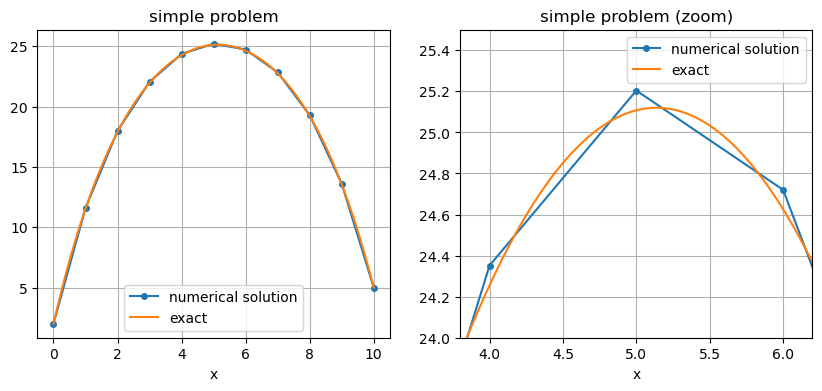

In [6]:
# number of elements
Nelem = 10
Ndofs = Nelem+1
# create mesh
x = np.linspace(0,L,Ndofs)
J = np.diff(x)/2

# connectivity array
gn = np.zeros((Nelem,2),dtype=int)
gn[0,:]=[0,1]
for iel in range(1,Nelem):
    gn[iel,0] = gn[iel-1,-1]
    gn[iel,1] = gn[iel,0] + 1 

# build basis function
fe_b, fe_dbdx = basis()
# elemental matrices/vectors
K,M,f = compute_elemental_matrices(fe_b, fe_dbdx, verbose=True)

# build matrix
A = sparse.lil_matrix((Ndofs,Ndofs))
b = np.zeros(Ndofs)

# loop over elements
for iel in range(0,Nelem):
    # global indices
    g = gn[iel,:]
    # add matrix contribution 
    local_mat = D/J[iel]*K + sigma*J[iel]*M
    for i,ind_i in enumerate(gn[iel,:]):
        b[ind_i] += q*J[iel]*f[i]
        for j,ind_j in enumerate(gn[iel,:]):
            A[ind_i,ind_j] += local_mat[i,j] 
# boundary conditions
A[0,:] = 0
A[0,0] = 1
A[-1,:] = 0        
A[-1,-1] = 1        
b[0] = u_left
b[-1] = u_right
# solve sparse system of equations
u = linalg.spsolve(A.tocsc(), b)

# plot
fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].plot(x,      u, marker='o', ms=4, label='numerical solution')
axs[0].plot(x_fine, exact(x_fine), label='exact')
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel('x')
axs[0].set_title('simple problem')

# zoom
axs[1].plot(x,      u, marker='o', ms=4, label='numerical solution')
axs[1].plot(x_fine, exact(x_fine), label='exact')
axs[1].grid(True)
axs[1].legend()
axs[1].set_xlabel('x')
axs[1].set_title('simple problem (zoom)')
axs[1].set_xlim([3.8,6.2])
axs[1].set_ylim([24,25.5])
plt.show()

## Mesh-dependent (zone-wise) properties

Up to now, the data $D$, $\sigma$ and $q$ was uniform.

We will introduce the concept of geometry zones or regions. For now, we assume that all regions will have the same width.

Let us say we have 2 materials, index by 0 and 1. An alternating layout in the geometry could be:
| name |  |  |  |  |
| :- | -: | -: | -: | -: |
| region ID | 0 | 1 | 2 | 3 |
|material ID | 0 | 1 | 0 | 1|

However, this is just the material zones. A mesh may need to be much finer. For example, each zone will be cut into 10 elements, so for the example above, we would have 4 regions and 40 elements (and 41 vertices).

For now, each region has the same width, so cutting up the geometry and making sure that the element edges align with the region edges is easy. We will use non uniform meshes in another Notebook.

## Try to implement this update yourself, creating a new code possibly inspired by code in Step-0

## The answer is below but only look at it after genuinely trying to do it yourself

In [9]:
material_indices = [0,1]

D = np.array([2.,1.])
sigma = np.array([0.2,1.])
q = np.array([0.,10.])

# set seed
np.random.seed(123456789)
# pick 10 regions and distribute the material indices randomly in these 10 regions
imat_geo = np.random.choice(material_indices, size=10, replace=True)
print("Material layout is:",imat_geo)

Material layout is: [0 0 0 1 0 1 0 1 0 0]


## Solve on cooarse mesh

In [10]:
# number of elements (3 per region)
Nelem = 30
# update material layout
imat  = np.repeat(imat_geo,3)
print(imat)

Ndofs = Nelem+1
# create mesh
x = np.linspace(0,L,Ndofs)
J = np.diff(x)/2

# connectivity array
gn = np.zeros((Nelem,2),dtype=int)
gn[0,:]=[0,1]
for iel in range(1,Nelem):
    gn[iel,0] = gn[iel-1,-1]
    gn[iel,1] = gn[iel,0] + 1 

# build basis function
fe_b, fe_dbdx = basis()
# elemental matrices/vectors
K,M,f = compute_elemental_matrices(fe_b, fe_dbdx)

# build matrix
A = sparse.lil_matrix((Ndofs,Ndofs))
b = np.zeros(Ndofs)

# loop over elements
for iel in range(0,Nelem):
    # get material ID
    im = imat[iel]
    # global indices
    g = gn[iel,:]
    # add matrix contribution 
    local_mat = D[im]/J[iel]*K + sigma[im]*J[iel]*M
    for i,ind_i in enumerate(gn[iel,:]):
        b[ind_i] += q[im]*J[iel]*f[i]
        for j,ind_j in enumerate(gn[iel,:]):
            A[ind_i,ind_j] += local_mat[i,j] 
# boundary conditions
A[0,:] = 0
A[0,0] = 1
A[-1,:] = 0        
A[-1,-1] = 1        
b[0] = u_left
b[-1] = u_right
# solve sparse system of equations
u = linalg.spsolve(A.tocsc(), b)

# save results
x_coarse = np.copy(x)
u_coarse = np.copy(u)

[0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0]


## Solve on finer mesh
### I copy-pasted the previous Notebook cell and refined the mesh. 
Copy-pasting is bad practice. We will fix this in the next Notebook by using classes.

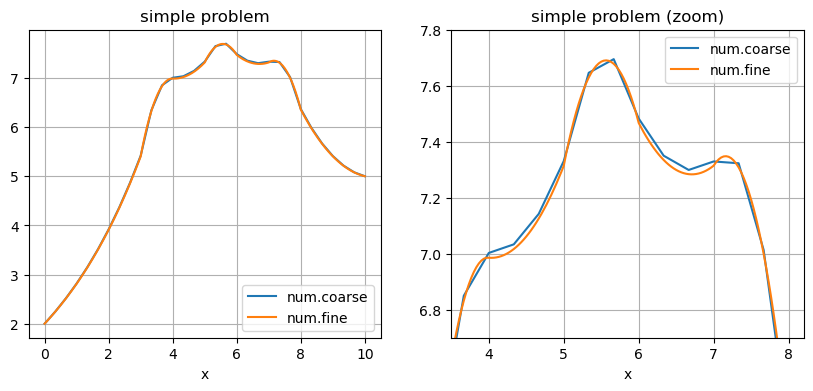

In [11]:

# increase mesh density
fac = 10
Nelem_fine = Nelem*fac
# update imat
imat_fine = np.repeat(imat,fac)

# the rest is the same

# number of elements
Ndofs = Nelem_fine+1
# create mesh
x = np.linspace(0,L,Ndofs)
J = np.diff(x)/2

# connectivity array
gn = np.zeros((Nelem_fine,2),dtype=int)
gn[0,:]=[0,1]
for iel in range(1,Nelem_fine):
    gn[iel,0] = gn[iel-1,-1]
    gn[iel,1] = gn[iel,0] + 1 

# no need to re-do the elemental matrices
# # build basis function
# fe_b, fe_dbdx = basis()
# # elemental matrices/vectors
# K,M,f = compute_elemental_matrices(fe_b, fe_dbdx, verbose=True)

# build matrix
A = sparse.lil_matrix((Ndofs,Ndofs))
b = np.zeros(Ndofs)

# loop over elements
for iel in range(0,Nelem_fine):
    # get material ID
    im = imat_fine[iel]
    # global indices
    g = gn[iel,:]
    # add matrix contribution 
    local_mat = D[im]/J[iel]*K + sigma[im]*J[iel]*M
    for i,ind_i in enumerate(gn[iel,:]):
        b[ind_i] += q[im]*J[iel]*f[i]
        for j,ind_j in enumerate(gn[iel,:]):
            A[ind_i,ind_j] += local_mat[i,j] 
# boundary conditions
A[0,:] = 0
A[0,0] = 1
A[-1,:] = 0        
A[-1,-1] = 1        
b[0] = u_left
b[-1] = u_right
# solve sparse system of equations
u = linalg.spsolve(A.tocsc(), b)

### Plots

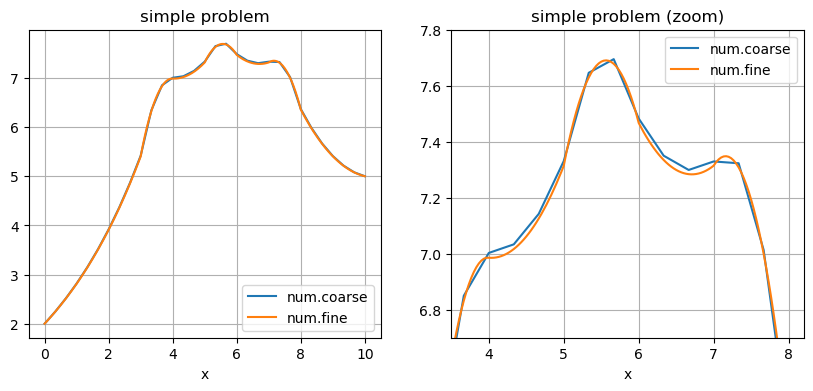

In [12]:
# plot
fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].plot(x_coarse,u_coarse, label='num.coarse')
axs[0].plot(x       ,u       , label='num.fine')
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel('x')
axs[0].set_title('simple problem')

# zoom
axs[1].plot(x_coarse,u_coarse, label='num.coarse')
axs[1].plot(x       ,u       , label='num.fine')
axs[1].grid(True)
axs[1].legend()
axs[1].set_xlabel('x')
axs[1].set_title('simple problem (zoom)')
axs[1].set_xlim([3.5,8.2])
axs[1].set_ylim([6.7,7.8])
plt.show()

In [28]:
class mydata:
    
    def __init__(self, cond_layout, qext_layout, nref, L, pb_dim=1):
        # cond_layout: 1D layout of the conductivity (material zones)
        # qext_layout: 1D layout of the heat source (material zones)
        #     Note the two layouts must be of compatible shape
        # nref: a scalar containing for the number of mesh refinement in x
        #     Note that mesh refinement is uniform in this code
        # L: a scalar for the Lx dimension
        
        # sanity checks
        if pb_dim != 1:
            raise ValueError('Only pb_dim=1 for now')
        if cond_layout.ndim !=1:
            raise ValueError('cond_layout: only dim=1 for now')
        if qext_layout.ndim !=1:
            raise ValueError('qext_layout: only dim=1 for now')
        if cond_layout.shape != qext_layout.shape:
            raise ValueError('cond_layout and qext_layout of different shapes')
        
        # refine the mesh and update material and source layouts
        repeats = np.asarray([nref], dtype=int)
        self.cond = self.repeat_array(cond_layout,repeats)
        self.qext = self.repeat_array(qext_layout,repeats)

        # mesh data
        # cells
        self.ncells_x = len(self.cond)
        # vertices
        self.npts_x = self.ncells_x + 1
        # coordinates
        self.x = np.linspace(0,L,self.npts_x)
        
        self.dx = L / self.ncells_x
        
        # nodal connectivity for cFEM
        self.connectivity()

            
    def repeat_array(self, arr,repeats):
        for dim,n in enumerate(repeats):
            arr = np.repeat(arr,n,axis=dim)
        return arr        
    
    
    def connectivity(self):
        self.gn = np.zeros((self.ncells_x,2),dtype=int)


        iel = 0
        for i in range(self.ncells_x):
            # left to right
            self.gn[iel,0] = iel
            self.gn[iel,1] = iel+1

            iel += 1    

# STOP HERE. OLD STUFF BELOW THAT I WILL DELETE LATER

___

# class for FEM solver

In [40]:
class FEM_solver:
    def __init__(self, data):
        
        # store the data received
        self.data = data
        
        # duplicates, shortcuts
        self.n_cells = data.ncells_x

        self.n_nodes = data.npts_x
        
        self.dx = np.copy(data.dx)

        # compute the cFEM basis functions
        self.basis()
        # compute the elemental matrices
        self.compute_elemental_matrices()
    
    
    def basis(self):
        # list of basis functions in [-1,1]^dim in counter-clockwise ordering
        self.b = []
        self.b.append(lambda u: (1-u)/2 )
        self.b.append(lambda u: (1+u)/2 )
        # their derivatives with respect to u
        self.dbdx = []
        self.dbdx.append(lambda u: -0.5 )
        self.dbdx.append(lambda u:  0.5 )
        
        
    def compute_elemental_matrices(self,verbose=False):
        # select spatial quadrature
        degree = 3
        [x_,w_] = np.polynomial.legendre.leggauss(degree)

        # matrices
        local_dofs = len(self.b)
        self.Q   = np.zeros(local_dofs)
        self.M   = np.zeros((local_dofs,local_dofs))
        self.Kxx = np.zeros((local_dofs,local_dofs))

        for (uq,wuq) in zip(x_,w_):
            for i,(fi,fxi) in enumerate(zip(self.b,self.dbdx)):
                self.Q[i]   += wuq*fi(uq)
                for j,(fj,fxj) in enumerate(zip(self.b,self.dbdx)):
                    self.M[i,j]   += wuq*fi (uq)*fj (uq)
                    self.Kxx[i,j] += wuq*fxi(uq)*fxj(uq)

        if verbose:
            print(self.Q)
            print(self.M)
            print(self.Kxx)
            print(self.Kyy)
            

    def assemble_system(self, bc):
        # assemble the cFEM system
        
        # sanity check
        if len(bc) !=2:
            raise ValueError('bc dictionary must have 2 keys')
                
        # stiffness matrix
        K = sparse.lil_matrix((self.n_nodes, self.n_nodes))
        # rhs
        rhs = np.zeros(self.n_nodes)

        # loop over elements
        for iel in range(self.n_cells):
            mat_prop = self.data.cond[iel]
            src_prop = self.data.qext[iel]
            for i,ind_i in enumerate(self.data.gn[iel,:]):
                rhs[ind_i] += src_prop * self.dx/2. * self.Q[i]
                for j,ind_j in enumerate(self.data.gn[iel,:]):
                    K[ind_i,ind_j] += mat_prop * 2/self.dx * self.Kxx[i,j] 

        # apply bc
        dir_nodes = []
        T_dir = []
        if bc['xmin']['type'] != 'refl':
            dir_nodes.append( 0 )
            T_dir.append(bc['xmin']['value'])
        if bc['xmax']['type'] != 'refl':
            dir_nodes.append( self.n_nodes-1 )
            T_dir.append(bc['xmax']['value'])
        dir_nodes = np.asarray(dir_nodes)

        for i,inode in enumerate(dir_nodes):
            K[inode,:]     = 0.
            K[inode,inode] = 1.
            rhs[inode]     = T_dir[i]

        return K, rhs

    
    def solve_system(self, A, b):
        solution = linalg.spsolve(A.tocsc(), b)

        return solution   

# Example 1

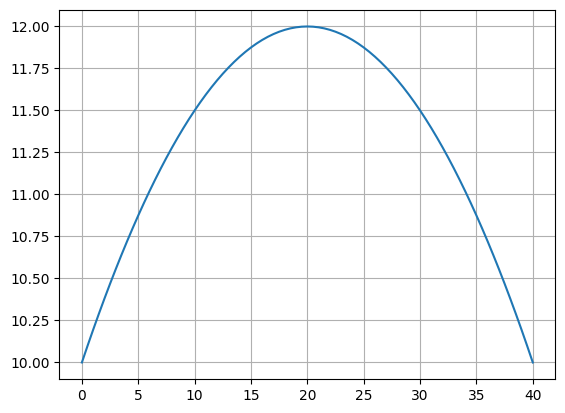

In [45]:
# data
cond = 100.*np.ones(4)
# cond[1] =1.
# cond[2] =1000.
# cond[0] =1.

qext = np.zeros_like(cond) +1.
# qext[0] = 100.
# qext[3] = 50.

# create data and solver objects
d = mydata(cond, qext, 20, 40.)
solver = FEM_solver(d)

# solve
bc = {}
bc['xmin']={'type':'dirichlet','value':10.}
bc['xmax']={'type':'dirichlet','value':10.}
A,b = solver.assemble_system(bc)
solution = solver.solve_system(A, b)

plt.figure()
plt.plot(d.x,solution)
plt.grid(True)
plt.show()